In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from methods import phase_kde
from models import Similitude3

In [3]:
train_steps = 5000
batch_size = 64
s_vals = np.linspace(-1, 0, 10) # rectification level

In [4]:
# Train model
models = []
losses = []
metrics = []
final_phases = []
initial_phases = []
for s in s_vals:
    model = Similitude3(scale=None, ncells=100, rectify = True, shift = s)
    if False:
        start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
        model.set_phases(start_phases)
    initial_phases.append(model.phases.clone().detach().numpy())
    loss_history = []
    for epoch in tqdm.trange(train_steps):
        
        r0 = torch.tensor(model.unit_cell.sample(batch_size), dtype = torch.float32)
        
        d = torch.tensor(np.random.uniform(0, 0.1, batch_size).astype("float32"))
        theta1 = torch.tensor(np.random.uniform(0, 2*np.pi, batch_size).astype("float32"))
        theta2 = torch.tensor(np.random.uniform(0, 2*np.pi, batch_size).astype("float32"))
        r1 = torch.stack((d*torch.cos(theta1), d*torch.sin(theta1)), dim = -1)
        r2 = torch.stack((d*torch.cos(theta2), d*torch.sin(theta2)), dim = -1)
        
        # phase perturbation
        d2 = 0*np.random.uniform(0, 0.1, model.ncells)
        theta3 = np.random.uniform(0, 2*np.pi, model.ncells)
        phase_eps = torch.tensor(np.stack((d2*np.cos(theta3), d2*np.sin(theta3)), axis = -1), dtype = torch.float32)
        
        rs = (r0, r1, r2, d, phase_eps)
        
        loss = model.train_step(rs)
        
        with torch.no_grad():
            rs = (r0, r1, r2, d, 0) # 0 noise for evaluation
            loss_history.append(model.loss_fn(rs).item())
    
    metrics.append([m.detach().numpy() for m in model.metric_metrics(rs)])

    final_phases.append(model.phases.clone().detach().numpy())
    losses.append(loss_history)
    models.append(model)

100%|██████████| 5000/5000 [00:11<00:00, 443.60it/s]


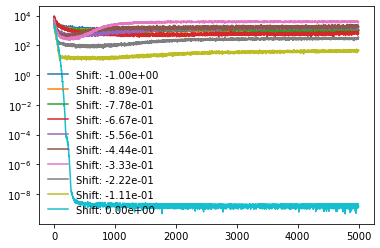

In [5]:
for shift, loss in zip(s_vals, losses):
    plt.semilogy(loss, label = f"Shift: {shift:.2e}")
plt.legend(frameon = False)

In [6]:
rs = model.unit_cell.sample(10*batch_size)
rs = (torch.tensor(rs,dtype=torch.float32), 0)

J = model.jacobian(rs)
metric_tensor = model.metric_tensor(J)

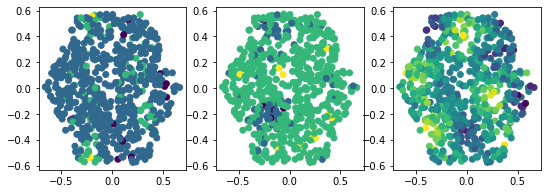

In [7]:
fig,axs = plt.subplots(ncols=3,figsize=(9,3))
axs[0].scatter(*rs[0].T,c=metric_tensor[...,0,0].detach())
axs[1].scatter(*rs[0].T,c=metric_tensor[...,1,1].detach())
axs[2].scatter(*rs[0].T,c=metric_tensor[...,1,0].detach())

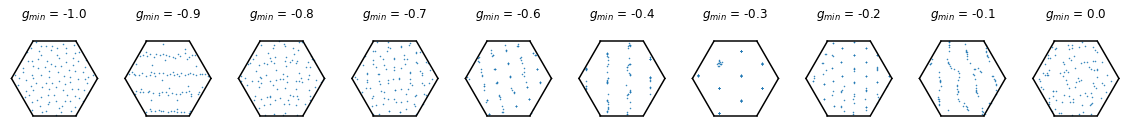

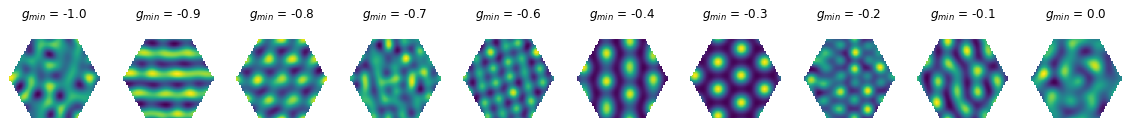

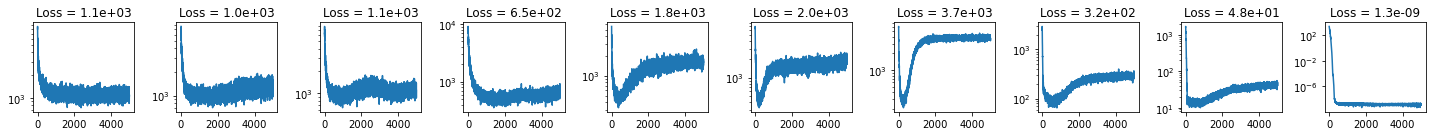

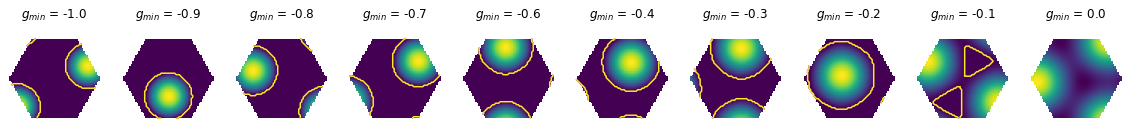

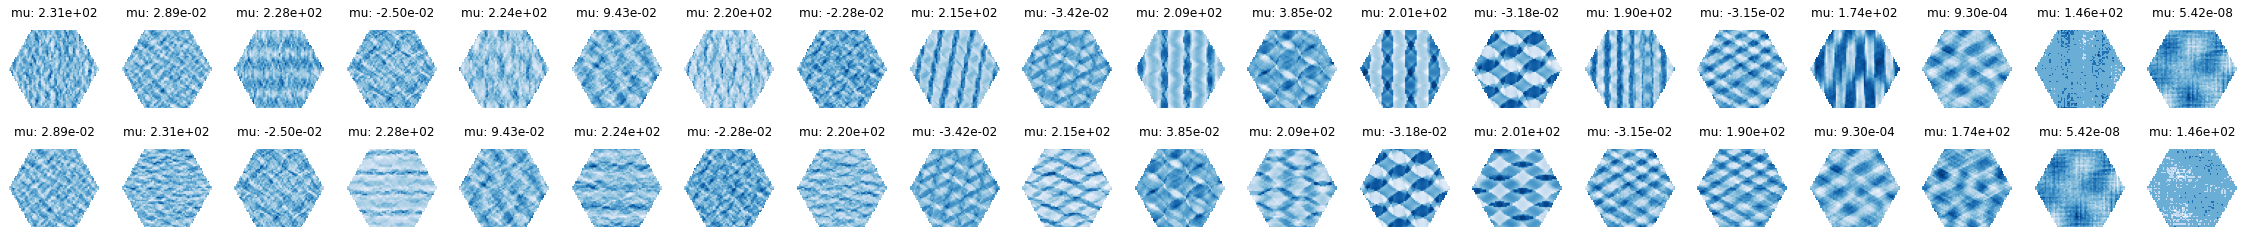

In [8]:
n = 64
eps = 1e-6
lim = 2/3
bins = np.linspace(-lim, lim, n)
#lim = np.amax(np.abs(mesh))

xx, yy = np.meshgrid(bins, bins)
mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(mesh)

try:
    fig, ax = plt.subplots(1, len(s_vals), figsize = (len(s_vals)*2, 2))
    for i, phases in enumerate(final_phases):
        ax[i].plot(*model.unit_cell.wrap(phases).T, ".",markersize = 1)
        #ax[i].plot(*phases.T, ".")

        model.unit_cell.plot(fig, ax[i], color = "k")
        ax[i].set_title(f"{'$g_{min}$'} = {s_vals[i]:.1f}")
        ax[i].axis("off")
        ax[i].axis("equal")
    plt.show()

    fig, ax = plt.subplots(1, len(s_vals), figsize = (len(s_vals)*2, 2))
    for i, phases in enumerate(final_phases):
        kernel, tiled_phases = phase_kde(model.unit_cell, model.unit_cell.wrap(phases), bw_method = 0.1)
        kde = kernel(mesh.T)
        kde[mask] = np.nan
        ax[i].imshow(kde.reshape(n,n), origin = "lower", extent = [-lim, lim, -lim, lim])
        ax[i].set_title(f"{'$g_{min}$'} = {s_vals[i]:.1f}")
        ax[i].axis("off")
        ax[i].axis("equal")
    plt.show()
except RecursionError:
    print("IT BROKE")

fig, ax = plt.subplots(1, len(s_vals), figsize = (len(s_vals)*2, 2))
for i, loss in enumerate(losses):
    ax[i].semilogy(loss)
    ax[i].set_title(f"Loss = {loss[-1]:.1e}")
    #ax[i].axis("off")
    #ax[i].axis("equal")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(s_vals), figsize = (len(s_vals)*2, 2))
for i, model in enumerate(models):
    G = model((torch.tensor(mesh, dtype = torch.float32),0)).detach().numpy()
    levels = [0 + eps, eps + 1*eps]

    G[mask] = np.nan
    G = np.reshape(G, (n, n, -1))
    ax[i].contour(xx, yy, G[...,0], levels = levels)
    ax[i].imshow(G[...,0], origin = "lower", extent = [-lim, lim, -lim, lim])
    ax[i].set_title(f"{'$g_{min}$'} = {s_vals[i]:.1f}")
    ax[i].axis("off")
    ax[i].axis("equal")
plt.show()

fig, ax = plt.subplots(2, 2*len(s_vals), figsize = (len(s_vals)*4, 4))
for i, model in enumerate(models):
    J = model.jacobian((torch.tensor(mesh, dtype = torch.float32),0))
    metric = model.metric_tensor(J).detach().numpy()
    metric[mask] = np.nan
    metric = np.reshape(metric, (n, n, 2, 2))
    
    currcol = i*2 # 0, 0, 2, 2, 

    for j in range(4):
        row = j // 2
        col = j % 2
        ax[row, currcol + col].imshow(metric[:,:,row,col], cmap = "Blues")
        num = f"{row}{col}"
        title = f"$g_{{{num}}}$\n"
        ax[row, currcol + col].set_title(f"mu: {np.nanmean(metric[:,:,row,col]):.2e}")
        ax[row, currcol + col].axis("off")
    
plt.show()

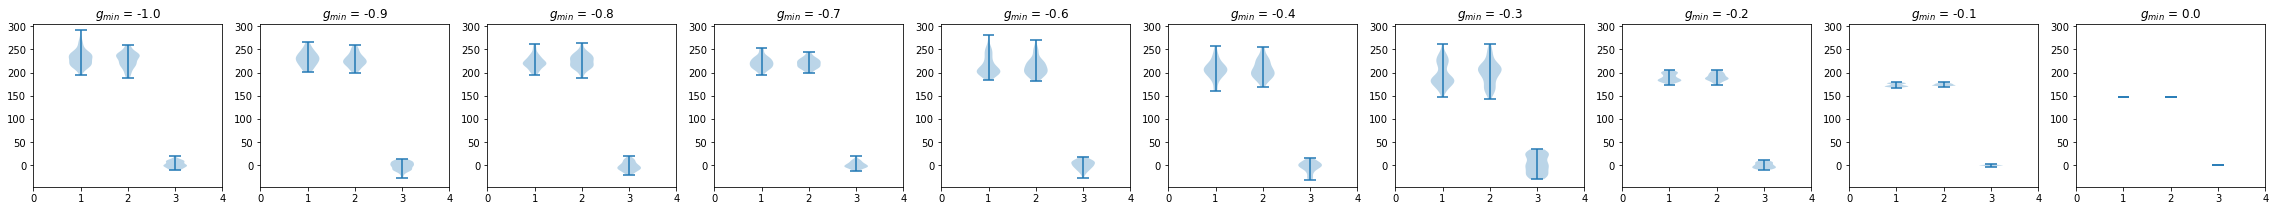

In [11]:
fig, ax = plt.subplots(1, len(metrics), figsize = (4*len(metrics), 3))
ymin = np.amin(metrics)*1.5
ymax = np.amax(metrics)*1.05
for i, metric in enumerate(metrics):
    ax[i].violinplot(metric)
    ax[i].axis([0, 4, ymin, ymax])
    ax[i].set_title(f"{'$g_{min}$'} = {s_vals[i]:.1f}")